In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [ ]:

%cd /content
!curl -L "https://www.dropbox.com/scl/fi/3lnz0c7ycsjwcw4181ose/IMG_CLASSESfin.zip?rlkey=i8h9x6rzsdzjfoxt121vlqv65&dl=0" > IMG_CLASSES.zip; unzip IMG_CLASSES.zip; rm IMG_CLASSES.zip


/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    149      0 --:--:--  0:00:01 --:--:--   149
100   491    0   491    0     0    195      0 --:--:--  0:00:02 --:--:--   873
100 55.0M  100 55.0M    0     0  16.0M      0  0:00:03  0:00:03 --:--:--  113M
Archive:  IMG_CLASSES.zip
   creating: IMG_CLASSES/Tomato__Tomato_mosaic_virus/
  inflating: IMG_CLASSES/Tomato__Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG  
  inflating: IMG_CLASSES/Tomato__Tomato_mosaic_virus/006e354b-c054-4b72-a83c-e3feb038942e___PSU_CG 2330.JPG  
  inflating: IMG_CLASSES/Tomato__Tomato_mosaic_virus/00c07a77-15e6-4815-92d4-8d1e1afb7f3c___PSU_CG 2052.JPG  
  inflating: IMG_CLASSES/Tomato__Tomato_mosaic_virus/01b32f27-2b9b-4961-805b-8066bf4d90f1___PSU_CG 2417.JPG  
  inflating: IMG_CLASSES/Tomato__Tomato_mosaic_virus/021accd9-bbb2-4777-8f94

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/IMG_CLASSES",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2964 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 2 1 2 0 2 2 2 2 2 2 2 2 2 1 2 2 0 1 1 2 1 1 1 2 2 1 2 1 2 1]


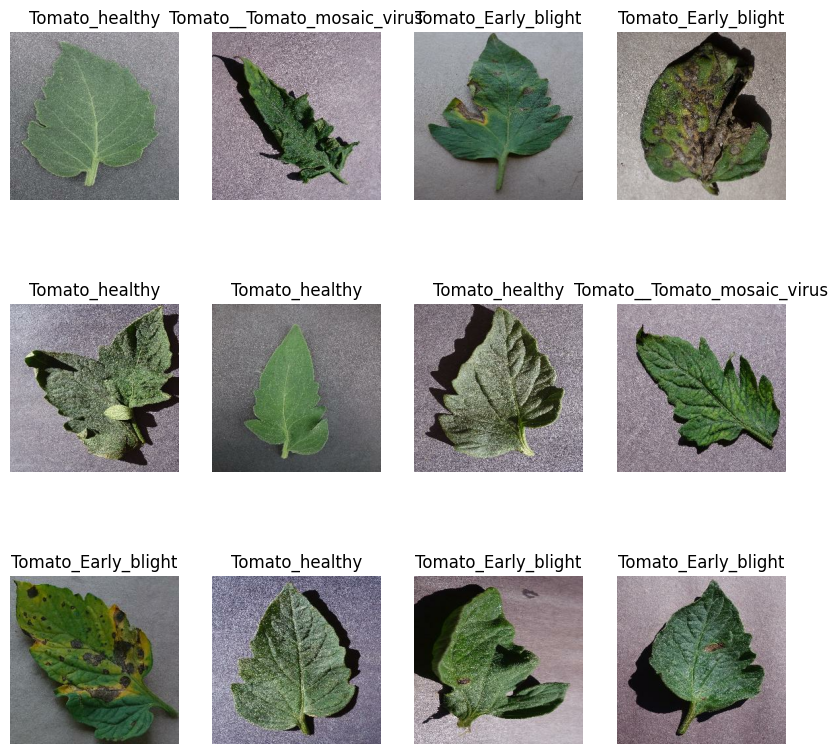

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
len(dataset)

93

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)



74

In [ ]:
len(val_ds)

9

In [ ]:
len(test_ds)

10

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
74/74 [==============================] - 23s 308ms/step - loss: 0.0863 - accuracy: 0.9703 - val_loss: 0.1550 - val_accuracy: 0.9583
Epoch 2/20
74/74 [==============================] - 23s 304ms/step - loss: 0.0854 - accuracy: 0.9754 - val_loss: 0.2107 - val_accuracy: 0.9340
Epoch 3/20
74/74 [==============================] - 23s 316ms/step - loss: 0.0946 - accuracy: 0.9690 - val_loss: 0.0922 - val_accuracy: 0.9618
Epoch 4/20
74/74 [==============================] - 22s 298ms/step - loss: 0.0697 - accuracy: 0.9788 - val_loss: 0.0784 - val_accuracy: 0.9757
Epoch 5/20
74/74 [==============================] - 23s 311ms/step - loss: 0.0781 - accuracy: 0.9741 - val_loss: 0.0251 - val_accuracy: 0.9931
Epoch 6/20
74/74 [==============================] - 23s 305ms/step - loss: 0.0709 - accuracy: 0.9754 - val_loss: 0.0859 - val_accuracy: 0.9722
Epoch 7/20
74/74 [==============================] - 23s 314ms/step - loss: 0.0475 - accuracy: 0.9868 - val_loss: 0.0177 - val_accuracy: 0.9965

In [ ]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 3s 27ms/step - loss: 0.0734 - accuracy: 0.9750


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

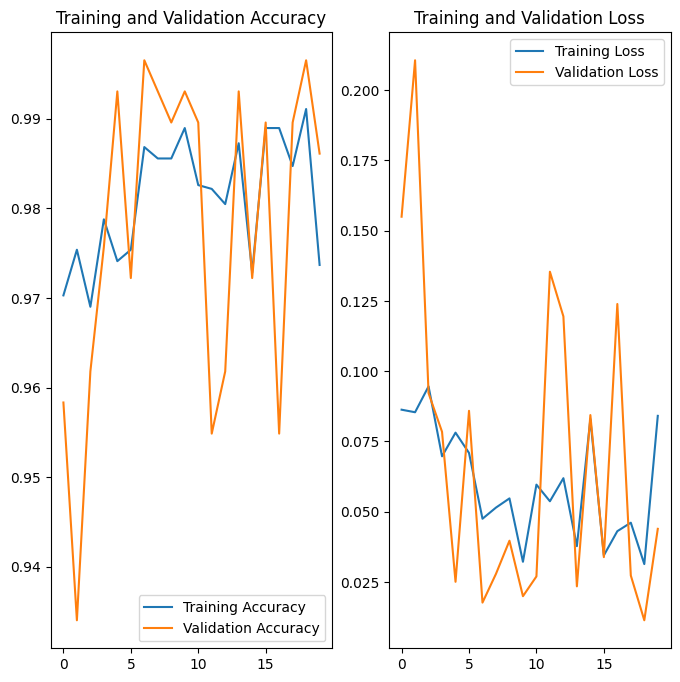

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Early_blight
1/1 [==============================] - 0s 145ms/step
predicted label: Tomato_Early_blight


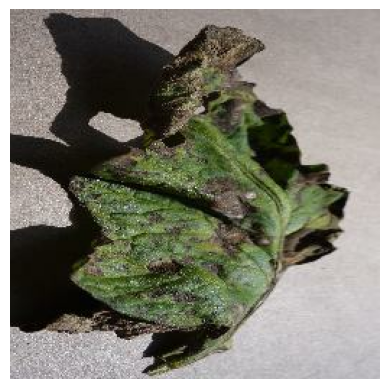

In [ ]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    plt.axis("off")
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


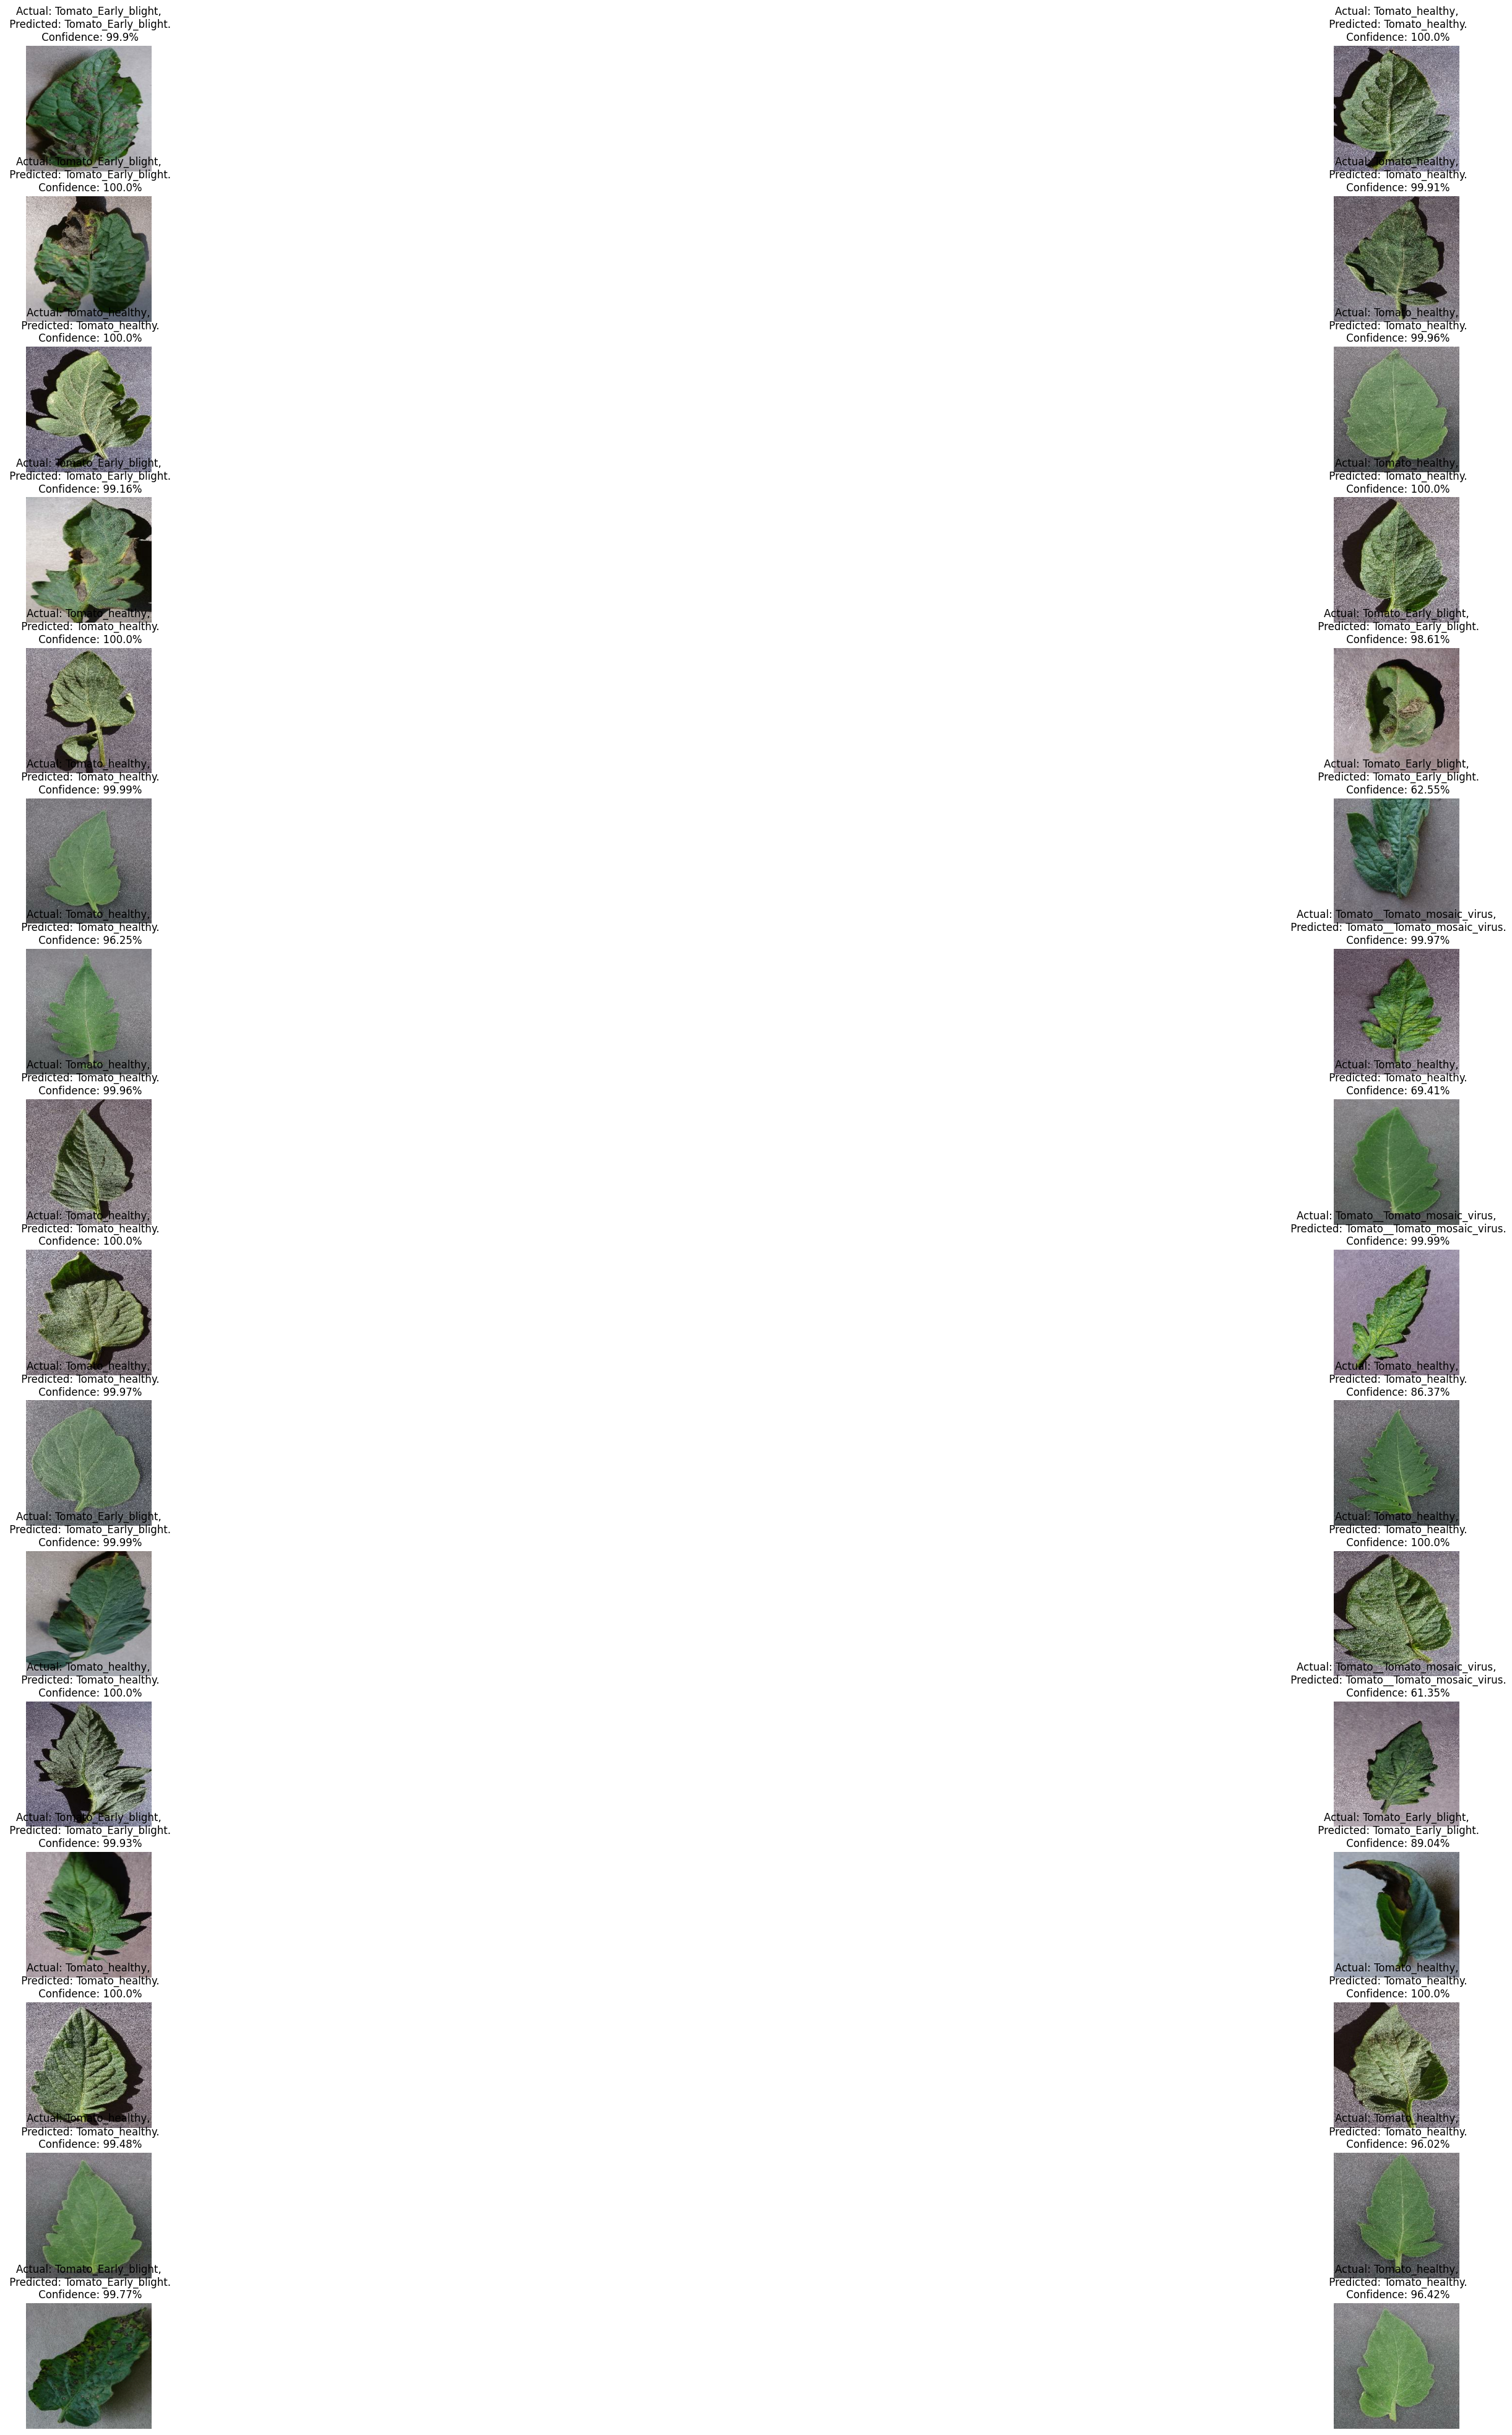

In [ ]:
plt.figure(figsize=(50, 50))

predicted_labels = []
true_labels = []
for images, labels in test_ds:

    for i in range(32):
        ax = plt.subplot(16, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        predicted_labels.append(predicted_class)
        true_labels.append(actual_class)

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
len(true_labels)

320

In [ ]:
predicted_labels

['Tomato_healthy',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_healthy',
 'Tomato_healthy',
 'Tomato_healthy',
 'Tomato_healthy',
 'Tomato_healthy',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_healthy',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'T

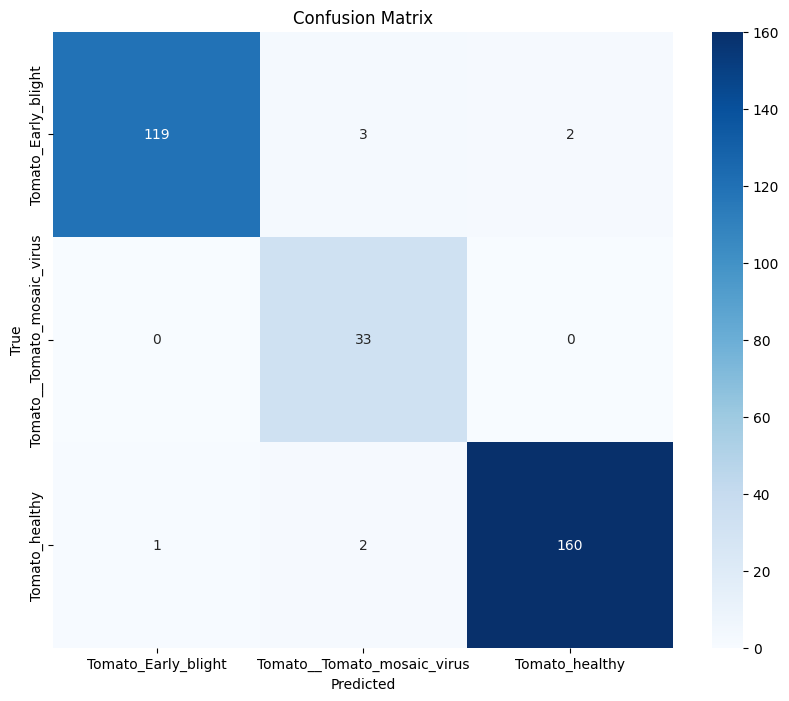

Classification Report:
                             precision    recall  f1-score   support

        Tomato_Early_blight       0.99      0.96      0.98       124
Tomato__Tomato_mosaic_virus       0.87      1.00      0.93        33
             Tomato_healthy       0.99      0.98      0.98       163

                   accuracy                           0.97       320
                  macro avg       0.95      0.98      0.96       320
               weighted avg       0.98      0.97      0.98       320



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_matrix = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))